共进行多项实验，只挑取几个相对合理的实验进行介绍

dnn-hy 实验一 by 孟

此项目所用第三方包主要包括：

pandas(数据操作包，用于对于类似excel表格的各种操作)
seaborn(数据可视化包)
sklearn(特征工程包)
keras(tensorflow更高一级的包, 对于简单模型，搭建十分方便)


python内置包

matplotlib(画图包)
numpy(python内置的数学工具包)



基础航班延误模型，2分类任务，下采样【-500，30】，【30-】，采用树模型惩罚来挑选重要特征，相比于不挑选重要特征效果更好(当然也取决于阈值的设定)，最终准确率66.5%左右。

个人想法：如果通过树模型来挑选特征，倒不如直接训练树模型, Rf, Gbdt, Xgboost, LightGbm


重要操作:

将日转化为星期几

取1/10数据进行操作

进行二分类，并下采样

离散变量进行one_hot编码，通过树惩罚模型挑选特征

模型采取 DNN 模型， 3层， 过拟合严重， 加入 dropout 后也无明显好结果。




In [1]:
import keras

Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [2]:
from __future__ import print_function

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import seaborn as sns

from sklearn import preprocessing
from sklearn.utils import shuffle 
from sklearn.model_selection import KFold, train_test_split
#from sklearn.feature_selection import SelectKBest
#from sklearn.feature_selection import chi2
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

#from keras.utils.np_utils import to_categorical
from keras import initializers
from keras.callbacks import Callback
from keras.layers import Input, Dense, Dropout
from keras.models import Model
from keras.optimizers import Adam, RMSprop

%matplotlib inline

导入数据，通过pandas.read_feather

In [3]:
data = pd.read_feather('/home/ubuntu/data/flight_data_7_18.feather')

data_num  #7096761
dropna()后 #7045804
取 1/10 的数据进行测试, 并 shuffle

In [4]:
data = data.dropna()
#data = shuffle(data)
data = data.sample(frac=0.1)
#print(data.info())

datatime 时间格式

In [5]:
data['sch_dep_time'].head()

430171    2015-06-22 11:45:00+08:00
963431    2015-08-19 22:50:00+08:00
1578318   2015-10-27 10:10:00+08:00
6936296   2017-05-16 11:45:00+08:00
1301572   2015-09-26 11:35:00+08:00
Name: sch_dep_time, dtype: datetime64[ns, Asia/Shanghai]

做切片操作， 分别为 年，月，日，时

In [6]:
data['sch_time_year'] = data['sch_dep_time'].map(lambda x: x.year)
data['sch_time_month'] = data['sch_dep_time'].map(lambda x: x.month)
data['sch_time_day'] = data['sch_dep_time'].map(lambda x: x.day)
data['sch_time_hour'] = data['sch_dep_time'].map(lambda x: x.hour)

将 日 转换成 星期几

In [7]:
data['sch_time_year'] = (data['sch_time_year'].map(lambda x: int(str(x)[2:])))
month_num = {1:6, 2:2, 3:2, 4:5, 5:0, 6:3, 7:5, 8:1, 9:4, 10:6, 11:2, 12:4}
data['year_num'] = data['sch_time_year'].map(lambda x: (int(x / 4) + x) % 7)
data['month_num']=  data['sch_time_month'].map(lambda x: month_num[x])
data['day_num'] = data['sch_time_day']
data['sch_time_day'] = data.apply(lambda x: (x['year_num'] + x['month_num'] + x['day_num'])%7, axis=1)
time_drop = ['year_num', 'month_num', 'day_num']
data = data.drop(time_drop,axis=1)

时 3个小时一个区间

In [8]:
data['sch_time_hour'] = data['sch_time_hour'].map(lambda x: 24 if x==0 else x)
for i in range(8):  #每3个小时一个区间
    data['sch_time_hour'] = data['sch_time_hour'].map(lambda x: 0+i if x>0+3*i and x<=3+3*i else x)

feature, label 分离

In [9]:
lb = ['delay_cat']
label = data[lb]
data = data.drop(lb, axis=1)
data = data.drop('sch_dep_time', axis=1)

对 float 数据进行 normalization

In [10]:
data1 = data.iloc[:,3:24]

data2 = data.iloc[:,0:3]
data3 = data.iloc[:,24:]
data2 = pd.concat([data2, data3], axis=1)
#print(data1.columns, data2.columns)
data1 = (data1 - data1.mean()) / data1.std()
#print(data.std())

In [11]:
data = pd.concat([data1, data2], axis=1)
data_train = data
label_train = label

In [12]:
label_train.head()

,delay_cat
430171,"[-500,30)"
963431,"[60,90)"
1578318,"[-500,30)"
6936296,"[-500,30)"
1301572,"[-500,30)"


二分类

In [13]:
label_train['feat1'] = 0
label_train['feat1'].loc[label.delay_cat == '[-500,30)'] = 1
label_train['feat2'] = 0
label_train['feat2'].loc[label.delay_cat != '[-500,30)'] = 1
label_train = label_train.loc[:, ['feat1', 'feat2']]

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


样本分布不均衡，采取降采样，使得正负样本数量 1：1

In [14]:
data = pd.concat([data_train, label_train], axis=1)
data['feat1'].value_counts()

1    482397
0    222183
Name: feat1, dtype: int64

In [15]:
from sklearn.utils import resample

data_majority = data[data.feat1==1]
data_minority = data[data.feat1==0]
data_majority_downsampled = resample(data_majority,
                                     replace=False,    # sample without replacement
                                     n_samples=222474,     # to match minority class
                                     random_state=1) # reproducible results
data_downsampled = pd.concat([data_majority_downsampled, data_minority])

In [16]:
data_downsampled = shuffle(data_downsampled)
lb = ['feat1', 'feat2']
label_train = data_downsampled[lb]
data_train = data_downsampled.drop(lb, axis=1)

对离散量进行 one_hot 编码

In [17]:
one_hot = ['sch_time_year','sch_time_month','sch_time_day','sch_time_hour','origin_airport','dest_airport','airline']
#db = ['origin_airport','dest_airport','airline']
#data_train = data_train.drop(db, axis=1)
data_train = pd.get_dummies(data_train, columns=one_hot)

数据记录 
0-47 时间以及天气特征
47-266 起飞机场名称
267-484 降落机场名称
485- 航线名称

In [18]:
#data_train.columns[200:266]  #47--266 Origin
#data_train.columns[466:484]   #267-484 dest
#data_train.columns[485:]   #airline
#data_2 = data_train.iloc[:,200:]
#data_1 = data_train.iloc[:,:200]

由于特征之间关系为非线性关系，所以通过树惩罚模型来选择重要特征

In [19]:
clf = ExtraTreesClassifier()
clf = clf.fit(data_train, label_train)

In [20]:
#sns.set(rc={'figure.figsize':(25,20)})
#delay_hm = sns.heatmap(airports_df_delay_drops, annot=True, fmt="d")
# delay_hm = sns.set(rc={'figure.figsize':(22,22)})
#plt.show()

选择合适的重要性阈值 importance 来筛选特征

In [21]:
importance = clf.feature_importances_ 
for i in range(len(importance)):
    if importance[i]>=1e-1 or importance[i]<=1e-5:
        importance[i] = 0
feature_importance_index = np.where(importance!=0)
feature_importance_index
#len(feature_importance_index)

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
         66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  79,
         80,  81,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,
         94,  95,  96,  97,  98,  99, 100, 101, 103, 104, 105, 106, 107,
        108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120,
        121, 122, 123, 125, 127, 128, 129, 130, 132, 133, 134, 135, 136,
        137, 138, 139, 140, 142, 143, 144, 145, 146, 147, 148, 149, 150,
        151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163,
        164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176,
        177, 178, 179, 180, 181, 182, 183, 184, 185

In [22]:
feature_importance_index = np.squeeze(np.array(feature_importance_index))

train, test 分离

In [23]:
data_train, data_test, label_train, label_test = train_test_split(data_train, label_train, test_size=0.2, random_state=2)

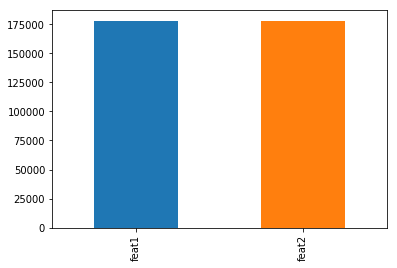

In [24]:
label_train.sum().plot.bar()

画 train , validation 的 loss, accuracy 图

In [25]:
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = {'batch':[], 'epoch':[]}
        self.accuracy = {'batch':[], 'epoch':[]}
        self.val_loss = {'batch':[], 'epoch':[]}
        self.val_acc = {'batch':[], 'epoch':[]}

    def on_batch_end(self, batch, logs={}):
        self.losses['batch'].append(logs.get('loss'))
        self.accuracy['batch'].append(logs.get('acc'))
        self.val_loss['batch'].append(logs.get('val_loss'))
        self.val_acc['batch'].append(logs.get('val_acc'))

    def on_epoch_end(self, epoch, logs={}):
        self.losses['epoch'].append(logs.get('loss'))
        self.accuracy['epoch'].append(logs.get('acc'))
        self.val_loss['epoch'].append(logs.get('val_loss'))
        self.val_acc['epoch'].append(logs.get('val_acc'))

    def loss_plot(self, loss_type):
        iters = range(len(self.losses[loss_type]))
        plt.figure()
        # acc
        plt.plot(iters, self.accuracy[loss_type], 'r', label='train acc')
        # loss
        plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
        if loss_type == 'epoch':
            # val_acc
            plt.plot(iters, self.val_acc[loss_type], 'b', label='val acc')
            # val_loss
            plt.plot(iters, self.val_loss[loss_type], 'k', label='val loss')
        plt.grid(True)
        plt.xlabel(loss_type)
        plt.ylabel('acc-loss')
        plt.legend(loc="upper right")
        plt.show()

nn model, 简单的 3 层依然会过拟合

In [26]:
from keras.optimizers import SGD

input_size = len(data_train.columns)

inputs = Input(shape=(input_size,))

# a layer instance is callable on a tensor, and returns a tensor
x = Dense(128, activation='relu')(inputs)
#x = Dropout(0.5)(x)
#x = Dense(64, activation='relu')(x)
x = Dense(64, activation='relu', kernel_initializer=initializers.TruncatedNormal(mean=0.0, stddev=0.05, seed=None))(x)
#x = Dense(128, activation='relu')(x)
#x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(2, activation='softmax', name='ou')(x)

# This creates a model that includes
# the Input layer and three Dense layers
model = Model(inputs=inputs, outputs=predictions)

optimizer = RMSprop(lr=0.0001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [27]:
history = LossHistory()

In [28]:
model.fit(x=data_train,
          y=label_train,
          epochs=100,
          batch_size=256,
          #verbose=2,
          validation_split=0.2,
          callbacks=[history]
          )

Train on 284580 samples, validate on 71145 samples
Epoch 1/100
284580/284580 [==============================] - 7s 26us/step - loss: 0.6625 - acc: 0.6007 - val_loss: 0.6404 - val_acc: 0.6303
Epoch 2/100
284580/284580 [==============================] - 7s 24us/step - loss: 0.6407 - acc: 0.6308 - val_loss: 0.6309 - val_acc: 0.6401
Epoch 3/100
284580/284580 [==============================] - 7s 24us/step - loss: 0.6334 - acc: 0.6400 - val_loss: 0.6261 - val_acc: 0.6462
Epoch 4/100
284580/284580 [==============================] - 7s 24us/step - loss: 0.6291 - acc: 0.6442 - val_loss: 0.6234 - val_acc: 0.6486
Epoch 5/100
284580/284580 [==============================] - 7s 24us/step - loss: 0.6257 - acc: 0.6478 - val_loss: 0.6214 - val_acc: 0.6509
Epoch 6/100
284580/284580 [==============================] - 7s 24us/step - loss: 0.6230 - acc: 0.6511 - val_loss: 0.6196 - val_acc: 0.6528
Epoch 7/100
284580/284580 [==============================] - 7s 24us/step - loss: 0.6207 - acc: 0.6542 - val_

Epoch 59/100
284580/284580 [==============================] - 8s 28us/step - loss: 0.5725 - acc: 0.7000 - val_loss: 0.6122 - val_acc: 0.6698
Epoch 60/100
284580/284580 [==============================] - 8s 28us/step - loss: 0.5721 - acc: 0.7002 - val_loss: 0.6121 - val_acc: 0.6681
Epoch 61/100
284580/284580 [==============================] - 8s 28us/step - loss: 0.5716 - acc: 0.6999 - val_loss: 0.6130 - val_acc: 0.6689
Epoch 62/100
284580/284580 [==============================] - 8s 28us/step - loss: 0.5711 - acc: 0.7009 - val_loss: 0.6126 - val_acc: 0.6688
Epoch 63/100
284580/284580 [==============================] - 8s 28us/step - loss: 0.5706 - acc: 0.7012 - val_loss: 0.6121 - val_acc: 0.6686
Epoch 64/100
284580/284580 [==============================] - 8s 28us/step - loss: 0.5697 - acc: 0.7021 - val_loss: 0.6136 - val_acc: 0.6684
Epoch 65/100
284580/284580 [==============================] - 8s 28us/step - loss: 0.5700 - acc: 0.7021 - val_loss: 0.6126 - val_acc: 0.6693
Epoch 66/100


调参能有小幅度提升，但都在66.5%附近，没有5%的提升，所以放弃

In [29]:
score = model.evaluate(x=data_test,
                       y=label_test
                       )

print('Test score:', score[0])
print('Test accuracy:', score[1])


88932/88932 [==============================] - 4s 44us/step
Test score: 0.6220919212359668
Test accuracy: 0.6656996356766968


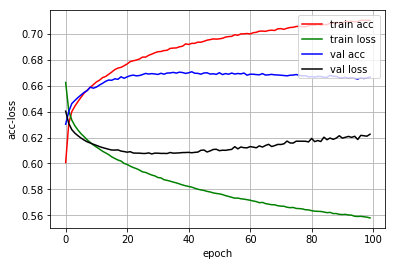

In [30]:
#绘制acc-loss曲线
history.loss_plot('epoch')

In [31]:
dense1_layer_model = Model(inputs=model.input,  
                                     outputs=model.get_layer('ou').output)  
#以这个model的预测值作为输出 
dense1_output = dense1_layer_model.predict(data_test)  
  
print(dense1_output.shape)  
print(dense1_output[30:60])

(88932, 2)
[[0.79982984 0.20017017]
 [0.22347274 0.7765272 ]
 [0.57646954 0.42353043]
 [0.10053978 0.8994602 ]
 [0.78566957 0.21433045]
 [0.3199546  0.68004537]
 [0.21628714 0.7837128 ]
 [0.399895   0.600105  ]
 [0.68988746 0.3101125 ]
 [0.2763893  0.72361076]
 [0.49354813 0.5064519 ]
 [0.50335556 0.49664444]
 [0.07665477 0.9233452 ]
 [0.84294385 0.15705612]
 [0.1930811  0.8069189 ]
 [0.591469   0.40853107]
 [0.21617974 0.7838202 ]
 [0.57035387 0.42964613]
 [0.51708657 0.48291346]
 [0.32079804 0.679202  ]
 [0.516809   0.483191  ]
 [0.40118858 0.59881145]
 [0.09174817 0.90825176]
 [0.59168357 0.40831646]
 [0.06552513 0.9344749 ]
 [0.6571987  0.34280133]
 [0.35120317 0.6487968 ]
 [0.6022796  0.3977204 ]
 [0.7129908  0.28700918]
 [0.3716592  0.6283408 ]]


In [32]:
print(dense1_output[30:60])

[[0.79982984 0.20017017]
 [0.22347274 0.7765272 ]
 [0.57646954 0.42353043]
 [0.10053978 0.8994602 ]
 [0.78566957 0.21433045]
 [0.3199546  0.68004537]
 [0.21628714 0.7837128 ]
 [0.399895   0.600105  ]
 [0.68988746 0.3101125 ]
 [0.2763893  0.72361076]
 [0.49354813 0.5064519 ]
 [0.50335556 0.49664444]
 [0.07665477 0.9233452 ]
 [0.84294385 0.15705612]
 [0.1930811  0.8069189 ]
 [0.591469   0.40853107]
 [0.21617974 0.7838202 ]
 [0.57035387 0.42964613]
 [0.51708657 0.48291346]
 [0.32079804 0.679202  ]
 [0.516809   0.483191  ]
 [0.40118858 0.59881145]
 [0.09174817 0.90825176]
 [0.59168357 0.40831646]
 [0.06552513 0.9344749 ]
 [0.6571987  0.34280133]
 [0.35120317 0.6487968 ]
 [0.6022796  0.3977204 ]
 [0.7129908  0.28700918]
 [0.3716592  0.6283408 ]]


In [33]:
print(dense1_output[dense1_output[:,0] > 0.5][0:20])

[[0.6190927  0.38090736]
 [0.6321893  0.36781073]
 [0.8439765  0.15602347]
 [0.7270957  0.27290434]
 [0.5790754  0.42092463]
 [0.7527262  0.24727383]
 [0.7277782  0.27222183]
 [0.6241927  0.37580732]
 [0.72621804 0.27378193]
 [0.55965185 0.44034815]
 [0.6669295  0.33307058]
 [0.89656305 0.10343696]
 [0.5284189  0.47158107]
 [0.66130525 0.3386948 ]
 [0.79982984 0.20017017]
 [0.57646954 0.42353043]
 [0.78566957 0.21433045]
 [0.68988746 0.3101125 ]
 [0.50335556 0.49664444]
 [0.84294385 0.15705612]]


In [34]:
del model